# Tarea 1: Classificaton Fine-tuning

In [2]:
# Librerías

import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

import torch
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs available:", torch.cuda.device_count())

from time import time
from datasets import *
from transformers import *
from sklearn.metrics import *
import matplotlib.pyplot as plt

Is CUDA available: True
CUDA version: 12.4
Number of GPUs available: 1


GroupViT models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version.Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.
TAPAS models are not usable since `tensorflow_probability` can't be loaded. It seems you have `tensorflow_probability` installed with the wrong tensorflow version. Please try to reinstall it following the instructions here: https://github.com/tensorflow/probability.


## Dataset

El split **MNLI** del dataset **GLUE** consiste en un par de oraciones (premisa e hipótesis) y una etiqueta indicando la relación entre ellas:

- _Entailment_: La hipótesis es una conclusión lógica de la premisa.
- _Neutral_: La hipótesis no puede ser determinada como verdadera o falsa basada en la premisa.
- _Contradiction_: La hipótesis contradice la premisa.

Además, este split contiene diferentes subconjuntos. Principalmente, usaremos el de _train_ para entrenar y los de _validation_ para evaluar la calidad del modelo. Los de _test_ los omitiremos para este trabajo.
- _Train_: Dataset que usaremos para entrenar el modelo.
- _MNLI-matched_ (MNLI-m): Dataset de validación creado a partir de las mismas categorías de los del conjunto de entrenamiento (e.g., noticias, ficción).
- _MNLI-mismatched_ (MNLI-mm): Dataset de validación creado a partir de diferentes categorías de los del conjunto de entrenamiento (e.g., discursos políticos, cartas).

Aquí la ficha del dataset para que podáis explorarla: https://huggingface.co/datasets/nyu-mll/glue

In [4]:
# pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:
      Successfully uninstalled huggingface-hub-0.33.1
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_s

In [3]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

dataset = load_dataset("glue", "mnli")
dataset

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

Con el único motivo de no demorar los tiempos de entrenamiento. Filtraremos el dataset y nos quedaremos solo con los registros que tenga longitud del campo _premise_ inferior a 20.

El resto de la práctica se pide trabajarla sobre la variable `ds_tarea`.

In [4]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def filter_rows(x):
    return len(x['premise'])<20
ds_tarea = dataset.filter(filter_rows)

assert len(ds_tarea['train']) == 13635
assert len(ds_tarea['validation_matched']) == 413
assert len(ds_tarea['validation_mismatched']) == 296

ds_tarea

Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9847 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 288
    })
})

## Modeling

En este apartado es donde tendréis que realizar todo el trabajo de la práctica. El formato, el análisis, el modelo escogido y cualquier proceso intermedio que consideréis es totalmente libre. Sin embargo, hay algunas pautas que tendréis que cumplir:

- La variable `model_checkpoint` debe almacenar el nombre del modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `model` y la variable `tokenizer` almacenarán, respectivamente, el modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `trainer` almacenará el _Trainer_ de 🤗 que, en la siguiente sección utilizaréis para entrenar el modelo.
- Debe existir una función llamada `preprocess_function` que realice la tokenización y, si lo consideráis oportuno, transformaciones de las _features_.

Nota: En el _tokenizer_, es obligatorio que el argumento `padding` sea distinto de `False` y que su salida sean **tensores** de pytorch.

In [ ]:
type(ds_tarea)
print(ds_tarea.keys())
print(ds_tarea.num_rows)
print(ds_tarea.num_columns)
print(ds_tarea.column_names)

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])
{'train': 13635, 'validation_matched': 413, 'validation_mismatched': 296, 'test_matched': 382, 'test_mismatched': 288}
{'train': 4, 'validation_matched': 4, 'validation_mismatched': 4, 'test_matched': 4, 'test_mismatched': 4}
{'train': ['premise', 'hypothesis', 'label', 'idx'], 'validation_matched': ['premise', 'hypothesis', 'label', 'idx'], 'validation_mismatched': ['premise', 'hypothesis', 'label', 'idx'], 'test_matched': ['premise', 'hypothesis', 'label', 'idx'], 'test_mismatched': ['premise', 'hypothesis', 'label', 'idx']}


In [5]:
from transformers import TrainingArguments, Trainer

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3) # Assuming 3 labels for classification

def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length', max_length=128, return_tensors='pt')





tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.53.0",
  "vocab_size": 30522
}



vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/model.safetensors
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification 

In [24]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to=["tensorboard"],
)

PyTorch: setting up devices


In [25]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    pre = precision_score(labels, preds, average=None)
    rec = recall_score(labels, preds, average=None)
    return {
        "accuracy": acc,
        "precision0": pre[0],
        "precision1": pre[1],
        "precision2": pre[2],
        "recall0": rec[0],
        "recall1": rec[1],
        "recall2": rec[2],
    }


In [26]:

tokenized_ds = ds_tarea.map(preprocess_function, batched=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation_matched"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

## Training

In [27]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

start = time()

trainer.train()

end = time()
print(f">>>>>>>>>>>>> elapsed time: {(end-start)/60:.0f}m")

The following columns in the Training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hypothesis, idx, premise. If hypothesis, idx, premise are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 13,635
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2,559
  Number of trainable parameters = 66,955,779


Epoch,Training Loss,Validation Loss,Accuracy,Precision0,Precision1,Precision2,Recall0,Recall1,Recall2
1,0.742700,0.626532,0.733656,0.750000,0.702290,0.746479,0.734266,0.707692,0.757143
2,0.551400,0.550182,0.774818,0.777778,0.734375,0.808511,0.783217,0.723077,0.814286
3,0.367700,0.557199,0.791768,0.790210,0.753846,0.828571,0.790210,0.753846,0.828571


The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hypothesis, idx, premise. If hypothesis, idx, premise are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 413
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-853
Configuration saved in ./results/checkpoint-853/config.json
Model weights saved in ./results/checkpoint-853/model.safetensors
tokenizer config file saved in ./results/checkpoint-853/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-853/special_tokens_map.json
The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: hypothesis, idx, premise. If hypothesis, idx, premise are not expected by `DistilBertForSequenceClassification.forward`,  you can saf

>>>>>>>>>>>>> elapsed time: 9m


## Evaluation

In [28]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

print(f"**** EVALUACIÓN ****")
print(f"********\nTokenizer config:\n{tokenizer}")
print(f"\n\n********\nModel config:\n{model.config}")
print(f"\n\n********\nTrainer arguments:\n{trainer.args}")

**** EVALUACIÓN ****
********
Tokenizer config:
DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


********
Model config:
DistilBertConfig {
  "activation": "gelu"

In [29]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

sample = ds_tarea['validation_matched'][0]
inputs = preprocess_function(sample)
for key, value in inputs.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} es una instancia de torch.Tensor")
    else:
        print(f"{key} no es una instancia de torch.Tensor")

input_ids es una instancia de torch.Tensor
attention_mask es una instancia de torch.Tensor


In [30]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict(x):
    inputs = preprocess_function(x)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        return {'prediction': predictions.item()}

ds_predictions = ds_tarea.map(predict)

assert len(ds_predictions['train']) == 13635
assert len(ds_predictions['validation_matched']) == 413
assert len(ds_predictions['validation_mismatched']) == 296

ds_predictions

Map:   0%|          | 0/13635 [00:00<?, ? examples/s]

Map:   0%|          | 0/413 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 288
    })
})

*** train ***


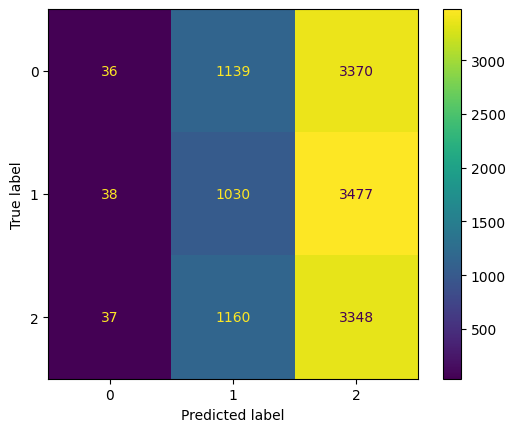

*** validation_matched ***


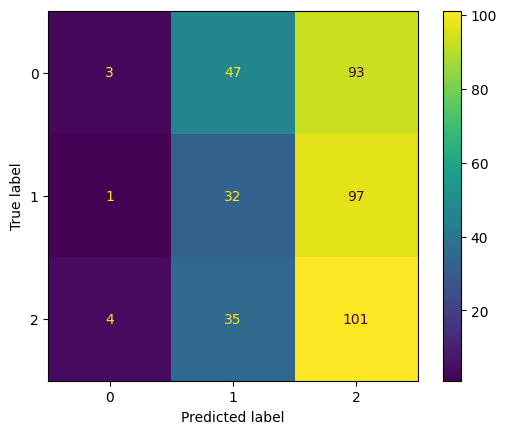

*** validation_mismatched ***


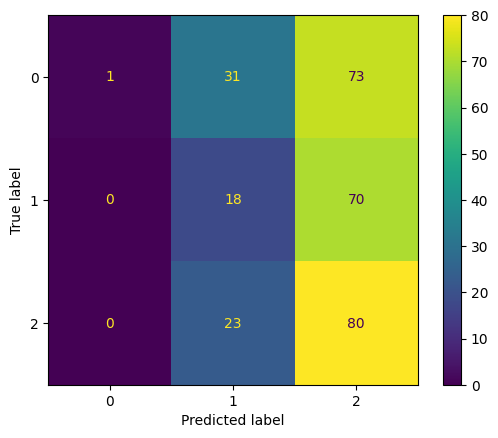

In [16]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print(f"*** {subset} ***")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [31]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

metrics = {}
for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    pre = precision_score(y_true=y_true, y_pred=y_pred, average=None)
    rec = recall_score(y_true=y_true, y_pred=y_pred, average=None)
    metrics[subset] = [acc] + pre.tolist() + rec.tolist()
    print(f"Subset: {subset}:")
    print(f"Accuracy: {acc:.2f} | Precision0: {pre[0]:.2f} | Precision1: {pre[1]:.2f} | Precision2: {pre[2]:.2f} | Recall0: {rec[0]:.2f} | Recall1: {rec[1]:.2f} | Recall2: {rec[2]:.2f}")
    print("-----\n")

Subset: train:
Accuracy: 0.90 | Precision0: 0.87 | Precision1: 0.90 | Precision2: 0.93 | Recall0: 0.92 | Recall1: 0.87 | Recall2: 0.91
-----

Subset: validation_matched:
Accuracy: 0.79 | Precision0: 0.79 | Precision1: 0.75 | Precision2: 0.83 | Recall0: 0.79 | Recall1: 0.75 | Recall2: 0.83
-----

Subset: validation_mismatched:
Accuracy: 0.71 | Precision0: 0.73 | Precision1: 0.61 | Precision2: 0.77 | Recall0: 0.69 | Recall1: 0.67 | Recall2: 0.76
-----



### Criterio de evaluación

La **nota final de la tarea1** estará relacionada con el resultado de las métricas de vuestro modelo en la combinación de *accuracy*, *precision* y *recall* para cada _split_ de datos.

El criterio de evaluación será el siguiente:
- La tarea1 se aprobará si el notebook se entrega sin fallos y con un modelo entrenado (independientemente de sus métricas).
- La tarea1 tiene un 10 si se cumple que las métricas de vuestro modelo entrenado igualan o superan los siguientes umbrales:

| Subset               | Accuracy | Precision0 | Precision1 | Precision2 | Recall0 | Recall1 | Recall2 |
|----------------------|----------|------------|------------|------------|---------|---------|---------|
| validation_matched    | 0.78     | 0.78       | 0.76       | 0.85       | 0.80    | 0.77    | 0.81    |
| validation_mismatched | 0.79     | 0.70       | 0.70       | 0.70       | 0.65    | 0.71    | 0.85    |

- Por cada valor inferior a dicha métrica, la tarea pierde 0.5 puntos (máximo 5.0 puntos de pérdida).

Nota: La nota que se calcula a continuación es orientativa y podría verse reducida en función del código de la entrega.

In [ ]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def calculo_nota(metric):

    vm_acc = float(metric['validation_matched'][0])
    vm_pre0 = float(metric['validation_matched'][1])
    vm_pre1 = float(metric['validation_matched'][2])
    vm_pre2 = float(metric['validation_matched'][3])
    vm_rec0 = float(metric['validation_matched'][4])
    vm_rec1 = float(metric['validation_matched'][5])
    vm_rec2 = float(metric['validation_matched'][6])
    vmm_acc = float(metric['validation_mismatched'][0])
    vmm_pre0 = float(metric['validation_mismatched'][1])
    vmm_pre1 = float(metric['validation_mismatched'][2])
    vmm_pre2 = float(metric['validation_mismatched'][3])
    vmm_rec0 = float(metric['validation_mismatched'][4])
    vmm_rec1 = float(metric['validation_mismatched'][5])
    vmm_rec2 = float(metric['validation_mismatched'][6])

    thresholds = {
        'vm_acc': 0.78, 'vm_pre0': 0.78, 'vm_pre1': 0.76, 'vm_pre2': 0.85,
        'vm_rec0': 0.80, 'vm_rec1': 0.77, 'vm_rec2': 0.81,
        'vmm_acc': 0.79, 'vmm_pre0': 0.70, 'vmm_pre1': 0.70, 'vmm_pre2': 0.70,
        'vmm_rec0': 0.65, 'vmm_rec1': 0.71, 'vmm_rec2': 0.85,
    }
    values = {
        'vm_acc': vm_acc, 'vm_pre0': vm_pre0, 'vm_pre1': vm_pre1, 'vm_pre2': vm_pre2,
        'vm_rec0': vm_rec0, 'vm_rec1': vm_rec1, 'vm_rec2': vm_rec2,
        'vmm_acc': vmm_acc, 'vmm_pre0': vmm_pre0, 'vmm_pre1': vmm_pre1, 'vmm_pre2': vmm_pre2,
        'vmm_rec0': vmm_rec0, 'vmm_rec1': vmm_rec1, 'vmm_rec2': vmm_rec2,
    }

    nota = 10
    for key in thresholds:
        if values[key] < thresholds[key]:
            nota -= 0.5
    return max(nota, 5.0)

print(f"Tu nota de la tarea1 es: {calculo_nota(metrics)}")

# Task
Explain the error in the provided code, fix it if possible, and incorporate the fix into the code. If fixing is not possible, diagnose the error.

## Choose a model checkpoint

### Subtask:
Select a suitable pre-trained model checkpoint from the Hugging Face Hub for text classification and assign it to the `model_checkpoint` variable.


**Reasoning**:
I need to select a suitable pre-trained model checkpoint for text classification from the Hugging Face Hub and assign it to the `model_checkpoint` variable. I will choose a common and effective model for this task.

